## Libraries Import

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    f1_score, accuracy_score, precision_score, recall_score
)
import seaborn as sns




## Load and explore data

In [4]:
df = pd.read_csv("credit_card.csv")
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (3075, 12)

First few rows:
   actionnr  merchant_id  average_amount_transaction_day  transaction_amount  \
0         1   3160040998                           100.0              3000.0   
1         2   3160040998                           100.0              4300.0   
2         3   3160041896                           185.5              4823.0   
3         4   3160141996                           185.5              5008.5   
4         5   3160241992                           500.0             26000.0   

  is_declined  total_number_of_declines_day isforeigntransaction  \
0           N                             5                    Y   
1           N                             5                    Y   
2           Y                             5                    N   
3           Y                             8                    N   
4           N                             0                    Y   

  ishighriskcountry  daily_chargeback_avg_amt  sixmonth_avg_chbk_am

## Data Quality

In [6]:
print("Missing values")
print(df.isnull().sum())
print("\n Duplicate values")
print(df.duplicated().sum())
print("\nTarget Variable Distribution:")
print(df['isfradulent'].value_counts())
print("\nTarget Variable Percentage:")
print(df['isfradulent'].value_counts(normalize=True) * 100)

Missing values
actionnr                          0
merchant_id                       0
average_amount_transaction_day    1
transaction_amount                0
is_declined                       0
total_number_of_declines_day      0
isforeigntransaction              0
ishighriskcountry                 0
daily_chargeback_avg_amt          0
sixmonth_avg_chbk_amt             0
sixmonth_chbk_freq                0
isfradulent                       0
dtype: int64

 Duplicate values
0

Target Variable Distribution:
isfradulent
N    2627
Y     448
Name: count, dtype: int64

Target Variable Percentage:
isfradulent
N    85.430894
Y    14.569106
Name: proportion, dtype: float64


## Exploring Data

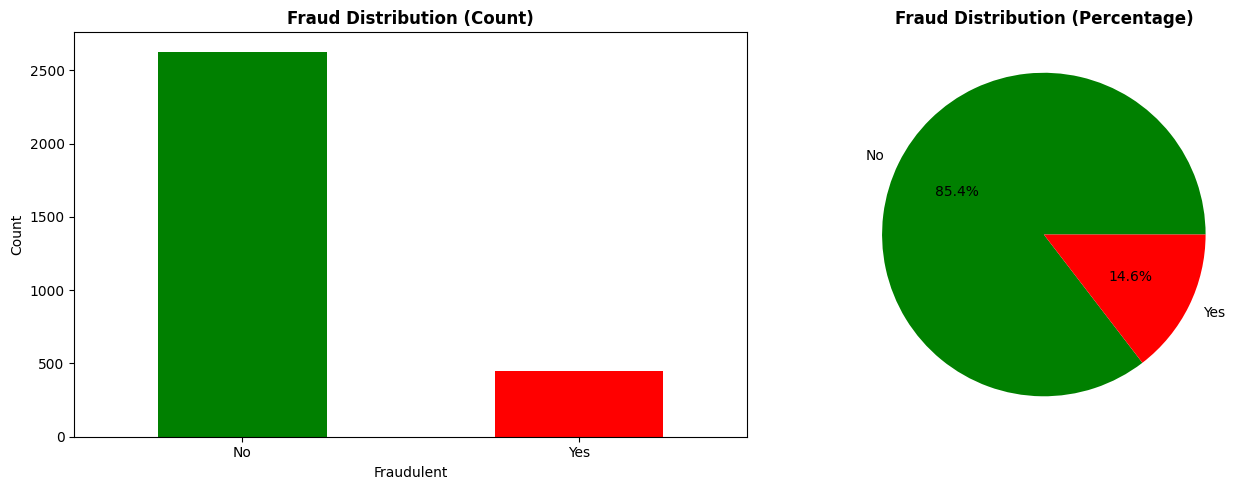

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['isfradulent'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Fraud Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Fraudulent')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

df['isfradulent'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                       colors=['green', 'red'], labels=['No', 'Yes'])
axes[1].set_title('Fraud Distribution (Percentage)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

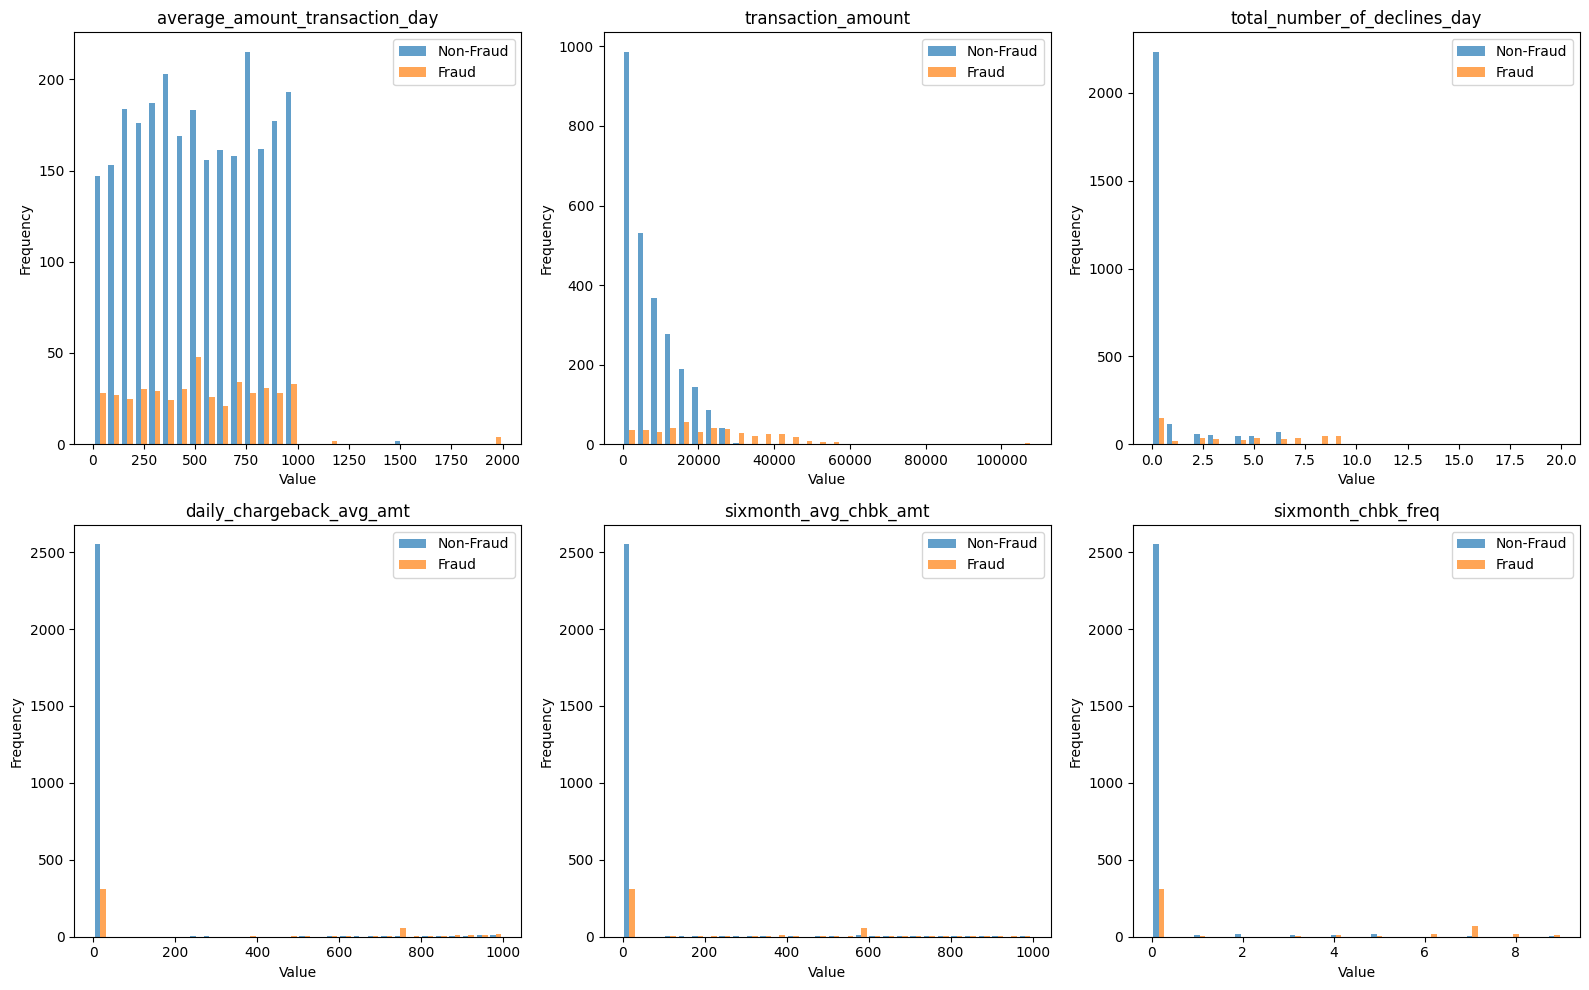

In [22]:
numerical_features = ['average_amount_transaction_day', 'transaction_amount', 
                     'total_number_of_declines_day', 'daily_chargeback_avg_amt',
                     'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq']

fig,axes = plt.subplots(2,3,figsize=(16,10))
axes = axes.ravel()
for idx,feature in enumerate(numerical_features):
    fraud = df[df['isfradulent']=='Y'][feature]
    non_fraud = df[df['isfradulent']=='N'][feature]
    axes[idx].hist([non_fraud, fraud], label=['Non-Fraud', 'Fraud'], bins=30, alpha=0.7)
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()


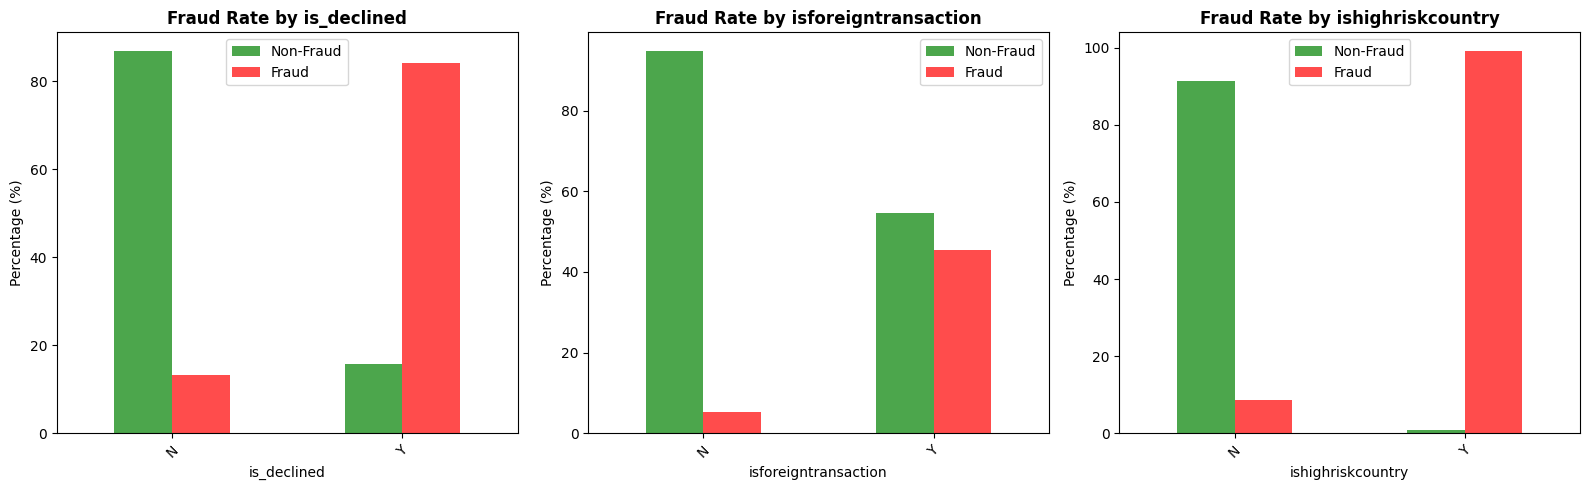

In [23]:
categorical_features = ['is_declined', 'isforeigntransaction', 'ishighriskcountry']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, feature in enumerate(categorical_features):
    cross_tab = pd.crosstab(df[feature], df['isfradulent'], normalize='index') * 100
    cross_tab.plot(kind='bar', ax=axes[idx], color=['green', 'red'], alpha=0.7)
    axes[idx].set_title(f'Fraud Rate by {feature}', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].legend(['Non-Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

## Data Processing

In [25]:
df_processed = df.copy()

df_processed = df_processed.drop('actionnr', axis=1)

categorical_cols = ['is_declined', 'isforeigntransaction', 'ishighriskcountry', 'isfradulent']

for col in categorical_cols:
    df_processed[categorical_cols] = (df[categorical_cols].apply(lambda c: c.map({"Y":1,"N":0})))

print("\nProcessed DataFrame:")
print(df_processed.head())
print("\nData Types:")
print(df_processed.dtypes)


Processed DataFrame:
   merchant_id  average_amount_transaction_day  transaction_amount  \
0   3160040998                           100.0              3000.0   
1   3160040998                           100.0              4300.0   
2   3160041896                           185.5              4823.0   
3   3160141996                           185.5              5008.5   
4   3160241992                           500.0             26000.0   

   is_declined  total_number_of_declines_day  isforeigntransaction  \
0            0                             5                     1   
1            0                             5                     1   
2            1                             5                     0   
3            1                             8                     0   
4            0                             0                     1   

   ishighriskcountry  daily_chargeback_avg_amt  sixmonth_avg_chbk_amt  \
0                  1                         0                 

In [26]:
df_processed["amount_deviation_ratio"] = df_processed["transaction_amount"]/df_processed["average_amount_transaction_day"]+1
df_processed["has_chargeback_history"] = ((df_processed["sixmonth_chbk_freq"] > 0) |(df_processed["sixmonth_avg_chbk_amt"] > 0)).astype(int)
df_processed["high_risk_profile"] = ((df_processed["isforeigntransaction"] == 1) &(df_processed["ishighriskcountry"] == 1)).astype(int)
df_processed["geo_risk_score"] = (df_processed["isforeigntransaction"] +df_processed["ishighriskcountry"])
df_processed["decline_pressure"] = (df_processed["total_number_of_declines_day"] > 1).astype(int)
df_processed["chargeback_risk_score"] = (df_processed["sixmonth_chbk_freq"] *df_processed["sixmonth_avg_chbk_amt"])
print("\nProcessed DataFrame:")
df_processed.head()





Processed DataFrame:


,merchant_id,average_amount_transaction_day,transaction_amount,is_declined,total_number_of_declines_day,isforeigntransaction,ishighriskcountry,daily_chargeback_avg_amt,sixmonth_avg_chbk_amt,sixmonth_chbk_freq,isfradulent,amount_deviation_ratio,has_chargeback_history,high_risk_profile,geo_risk_score,decline_pressure,chargeback_risk_score
0,3160040998,100.0,3000.0,0,5,1,1,0,0.0,0,1,31.0,0,1,2,1,0.0
1,3160040998,100.0,4300.0,0,5,1,1,0,0.0,0,1,44.0,0,1,2,1,0.0
2,3160041896,185.5,4823.0,1,5,0,0,0,0.0,0,1,27.0,0,0,0,1,0.0
3,3160141996,185.5,5008.5,1,8,0,0,0,0.0,0,1,28.0,0,0,0,1,0.0
4,3160241992,500.0,26000.0,0,0,1,1,800,677.2,6,1,53.0,1,1,2,0,4063.2


## Scaling

In [29]:
X = df_processed.drop('isfradulent', axis=1)
y = df_processed['isfradulent']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set fraud rate: {y_train.sum() / len(y_train) * 100:.2f}%")
print(f"Test set fraud rate: {y_test.sum() / len(y_test) * 100:.2f}%")

Features shape: (3075, 16)
Target shape: (3075,)

Features: ['merchant_id', 'average_amount_transaction_day', 'transaction_amount', 'is_declined', 'total_number_of_declines_day', 'isforeigntransaction', 'ishighriskcountry', 'daily_chargeback_avg_amt', 'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq', 'amount_deviation_ratio', 'has_chargeback_history', 'high_risk_profile', 'geo_risk_score', 'decline_pressure', 'chargeback_risk_score']

Training set size: 2460
Test set size: 615

Training set fraud rate: 14.55%
Test set fraud rate: 14.63%


In [55]:

imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)




## Handle class imbablance

In [56]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:")
print(f"Non-Fraud: {class_weight_dict[0]:.4f}")
print(f"Fraud : {class_weight_dict[1]:.4f}")

Class weights:
Non-Fraud: 0.5852
Fraud : 3.4358


## Model training

In [57]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    'SVM': SVC(
        random_state=42,
        class_weight='balanced',
        probability=True  
    )
}

results = {}

for name, model in models.items():
    
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'roc_auc': test_roc_auc,
        'precision': test_precision,
        'recall': test_recall,
        'y_pred': y_pred_test,
        'y_pred_proba': y_pred_proba_test
    }
    
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train F1-Score: {train_f1:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

Train Accuracy: 0.9907
Test Accuracy: 0.9870
Train F1-Score: 0.9685
Test F1-Score: 0.9560
Test ROC-AUC: 0.9988
Test Precision: 0.9457
Test Recall: 0.9667
Train Accuracy: 1.0000
Test Accuracy: 0.9919
Train F1-Score: 1.0000
Test F1-Score: 0.9718
Test ROC-AUC: 0.9873
Test Precision: 0.9885
Test Recall: 0.9556
Train Accuracy: 1.0000
Test Accuracy: 0.9902
Train F1-Score: 1.0000
Test F1-Score: 0.9663
Test ROC-AUC: 0.9759
Test Precision: 0.9773
Test Recall: 0.9556
Train Accuracy: 0.9870
Test Accuracy: 0.9870
Train F1-Score: 0.9568
Test F1-Score: 0.9560
Test ROC-AUC: 0.9973
Test Precision: 0.9457
Test Recall: 0.9667


## Confusion matrix

IndexError: index 3 is out of bounds for axis 0 with size 3

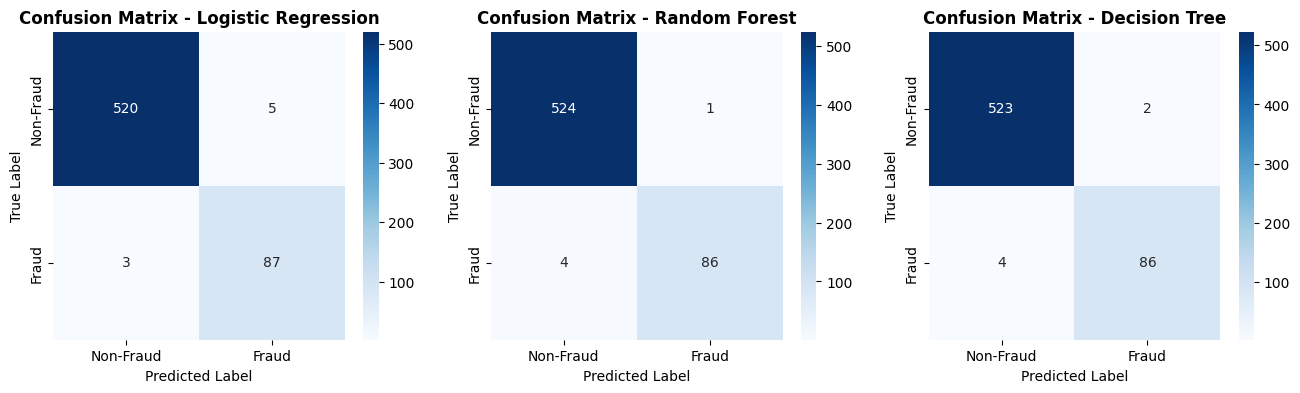

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[idx].set_title(f'Confusion Matrix - {name}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## ROC Curves

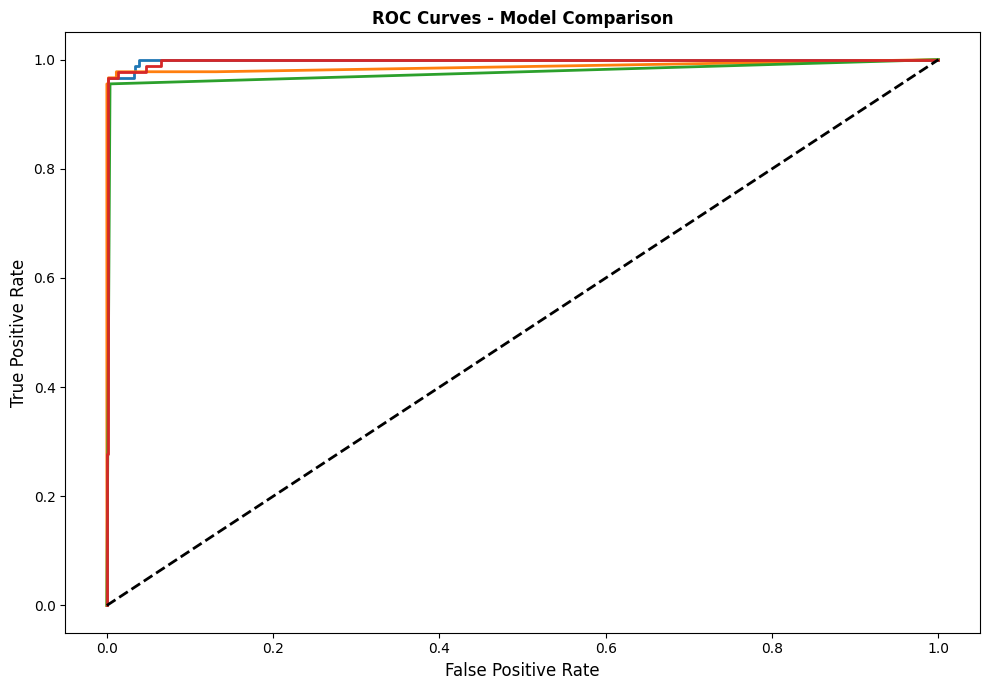

In [60]:
plt.figure(figsize=(10, 7))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = roc_auc_score(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontweight='bold')
plt.tight_layout()
plt.show()